# Train deepRetina

In [1]:
# A bit of setup
import numpy as np
from scipy.io import loadmat
import os.path as path
import matplotlib.pyplot as plt
from nems.utilities import rolling_window
from lnl_model_functions import *
from matplotlib.pyplot import *
from pyret.filtertools import getsta, filterpeak # input: (time,), stim (x,x,x,time), spikes (times,)
import pyret.visualizations as viz # note that this imports seaborn and messes up all plotting functions
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
import mpld3

# from time import time
# import re
# from os import listdir
# from os.path import isfile, join
# from scipy import misc
# import scipy.io


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages/pytz/__init__.py:29: UserWarning: Module IPython was already imported from /Users/lmcintosh/Git/ipython/IPython/__init__.pyc, but /Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages is being added to sys.path
  from pkg_resources import resource_stream


# Load data

#### Use normalized float32 stim

In [2]:
data_dir = '/Users/lmcintosh/Git/deepRGC/datasets/white_noise/'
metadata = np.load(path.join(data_dir, 'metadata.npz'))['metadata'].item()
stim  = np.memmap(path.join(data_dir, 'stim_norm.dat'), dtype=metadata['stim_norm_dtype'], 
                  mode='r', shape=metadata['stim_norm_shape'])
rates = np.memmap(path.join(data_dir, 'rates.dat'), dtype=metadata['rates_dtype'], 
                  mode='r', shape=metadata['rates_shape'])

### Smooth raw spike count with 10 ms std Gaussian to get PSTHs

In [3]:
rates_filt = np.zeros(rates.shape)
filt       = gaussian(x=np.linspace(-5,5,10), sigma=1, mu=0)
for cell in xrange(rates.shape[1]):
    rates_filt[:,cell] = np.convolve(rates[:,cell], filt, mode='same')

### Create 4d stim array where each data point is a 400ms (40 frame) movie

<matplotlib.colorbar.Colorbar instance at 0x3e0cd4440>

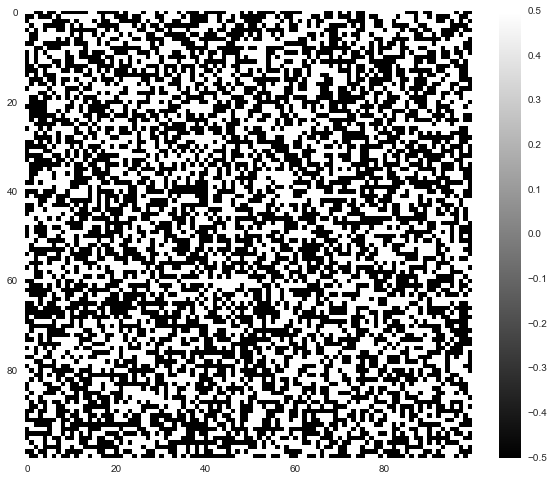

In [4]:
imshow(stim[:,:,0])
grid(False)
colorbar()

In [236]:
#stim_sliced = stim[34:-34, 34:-34,:]
stim_sliced = stim[52:64, 36:48]

In [237]:
X = rolling_window(stim_sliced, 40)
X = np.rollaxis(X, 2)
X = np.rollaxis(X, 3, 1)

In [238]:
X.shape

(299850, 40, 12, 12)

In [239]:
X.T.shape

(12, 12, 40, 299850)

### Truncate rates to appropriate time frame

In [240]:
y = rates_filt[X.shape[1]:]

### Show STA as sanity check that data looks right

In [241]:
cell = 9 # good center cells are 0, 5, 7. high fr cells are 3, 7, 8, 9

In [242]:
np.mean(y[:,cell] > 0)

0.31550108387527098

In [10]:
np.mean(X[:], dtype='float32')

1.2119666e-05

## STA on filtered rates

In [243]:
def sta(stimulus, spiketrain):
    if len(spiketrain.shape) > 1:
        sta = {}
        for cell in xrange(spiketrain.shape[1]):
            sta[cell] = np.zeros(stimulus[0].shape)
            for spi, sp in enumerate(spiketrain[:,cell]):
                if spi % 100000 == 0:
                        print spi
                        
                if sp == 0:
                    pass
                else:
                    sta[cell] += sp * stimulus[spi]
            sta[cell] /= len(spiketrain[:,cell] > 0)
            print cell
        return sta
            
    else:
        sta = np.zeros(stimulus[0].shape)
        for spi, sp in enumerate(spiketrain):
            if spi % 100000 == 0:
                    print spi

            if sp == 0:
                pass
            else:
                sta += sp * stimulus[spi]
        sta /= len(spiketrain > 0)
        return sta
        
#         numSpikes = len(spiketrain)
#         sta = np.dot(stimulus.T, spiketrain)
#         sta /= numSpikes
#         return sta.T    

In [244]:
X_sta = sta(X, y[:,cell])

0
100000
200000


## Alternate STA function for passing in random indices

In [13]:
def sta_memmap(indices, stim_memmap, spiketrain):
    """ spiketrain is size (indices,)
    """
    sta = np.zeros(stim_memmap[0].shape)
    for spi, sp in enumerate(spiketrain):
        if spi % 100000 == 0:
                print spi

        if sp == 0:
            pass
        else:
            sta += sp * stim_memmap[indices[spi]]
    sta /= len(spiketrain > 0)
    return sta

In [18]:
mask = np.random.choice(X.shape[0], size=100000)
X_sta_tmp = sta_memmap(mask, X, y[mask,cell])

0


In [16]:
tmp = X_sta.copy()

In [17]:
X_sta[0].shape

(32, 32)

<matplotlib.colorbar.Colorbar instance at 0x3e21df710>

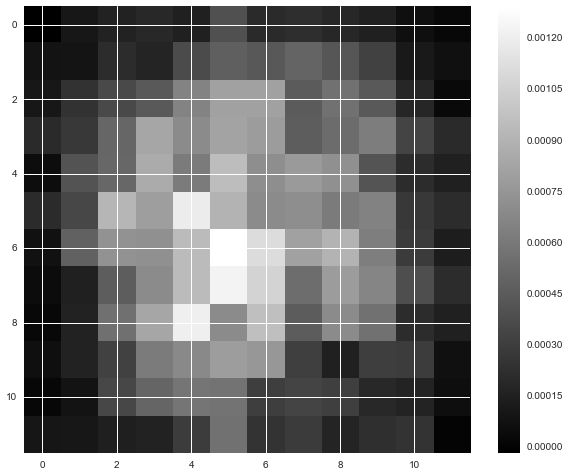

In [245]:
imshow(X_sta[33,:,:])
colorbar()

In [246]:
peaks = filterpeak(X_sta.T)

In [247]:
peaks

((5, 6, 33), array([6, 5]), 33)

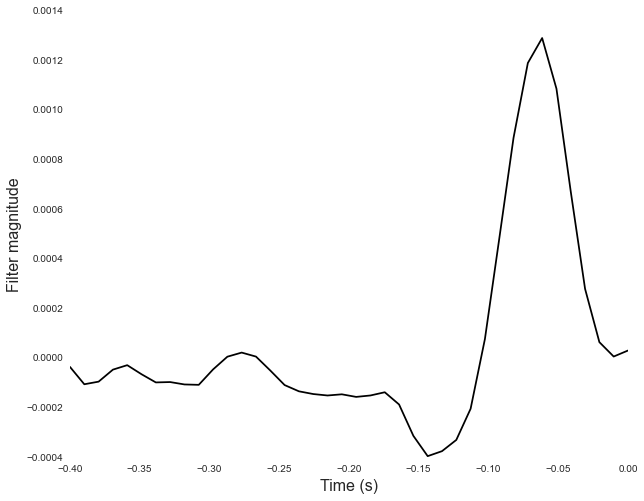

In [248]:
times = np.linspace(-0.01*X_sta.shape[0], 0, X_sta.shape[0])
plot(times, X_sta[:,peaks[1][0],peaks[1][1]], 'k')
xlim([np.min(times), 0])
xlabel('Time (s)', fontsize=16)
ylabel('Filter magnitude', fontsize=16)

In [249]:
subset = 1000
times = np.linspace(0, 0.01*len(y[:subset, cell]), len(y[:subset, cell]))
plot(times, y[:subset, cell], 'k')
xlabel('Time (s)', fontsize=16)
ylabel('Rates', fontsize=16)
mpld3.display()

# How well does an LN model predict spikes?

<matplotlib.colorbar.Colorbar instance at 0x3e50a4bd8>

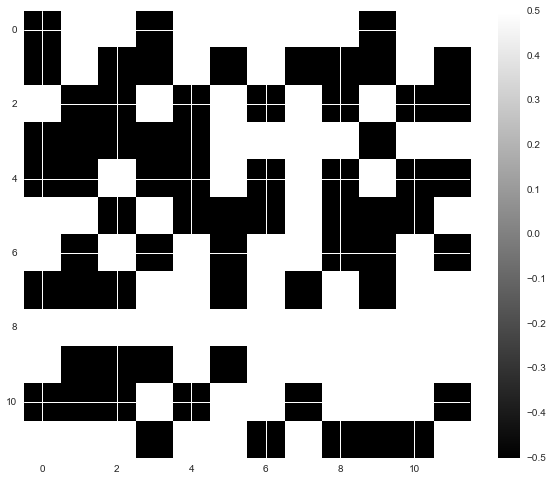

In [250]:
imshow(X[0,0,:,:])
colorbar()

In [210]:
# Make linear prediction. Assumes data is zero mean.
subset    = None
batchSize = 10000
if subset:
    X_subset = X[:subset]
    y_subset = y[:subset, cell]
    l_prediction = np.zeros(y_subset.shape)
    
    for it in xrange(y_subset.shape[0] / batchSize):
        l_prediction[it*batchSize:(it+1)*batchSize] = np.tensordot(X_subset[it*batchSize:(it+1)*batchSize], 
                                                                   X_sta, axes=3)
else:
    l_prediction = np.zeros(y[:,cell].shape)
    for it in xrange(X.shape[0] / batchSize + 1):
        l_prediction[it*batchSize:(it+1)*batchSize] = np.tensordot(X[it*batchSize:(it+1)*batchSize], X_sta, axes=3)

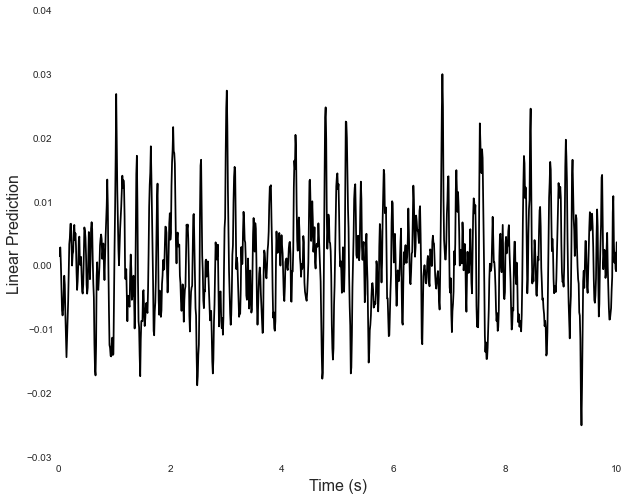

In [211]:
subset = 1000
times = np.linspace(0, 0.01*len(l_prediction[:subset]), len(l_prediction[:subset]))
plot(times, l_prediction[:subset],'k')
xlabel('Time (s)', fontsize=16)
ylabel('Linear Prediction', fontsize=16)

In [14]:
def logistic(x, a, b, c, d):
    return a/(1 + np.exp(-b*(x - c))) + d

def relu(x, a, b):
    return np.maximum(a*x + b, 0)

In [213]:
f = relu
subset = None
if subset:
    popt, pcov = curve_fit(f, l_prediction[:subset], y[:len(l_prediction[:subset]), cell])
else:
    popt, pcov = curve_fit(f, l_prediction, y[:,cell])

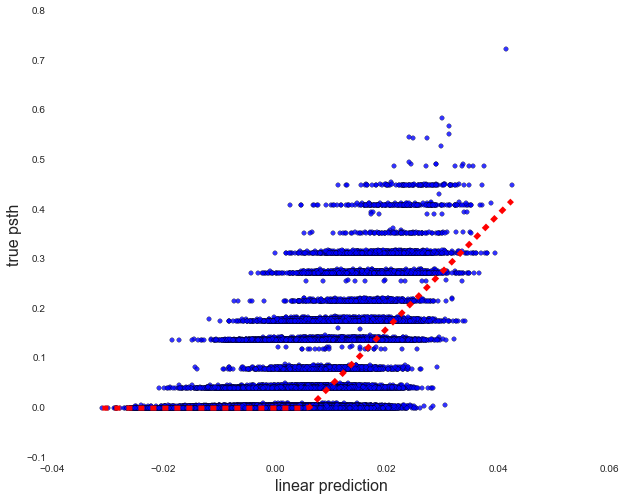

In [214]:
xs = np.linspace(np.min(l_prediction), np.max(l_prediction), 100)
scatter(l_prediction, y[:len(l_prediction),cell], alpha=0.8)
plot(xs, f(xs, *popt), 'r--', linewidth=5)
xlabel('linear prediction', fontsize=16)
ylabel('true psth', fontsize=16)

In [215]:
subset = None
batchSize = 10000
if subset:
    ln_prediction = np.zeros(y_subset.shape)

    for it in xrange(y_subset.shape[0] / batchSize):
        ln_prediction[it*batchSize:(it+1)*batchSize] = f(l_prediction[it*batchSize:(it+1)*batchSize], *popt)
else:
    
    ln_prediction = np.zeros(y[:,cell].shape)

    for it in xrange(X.shape[0] / batchSize + 1):
        ln_prediction[it*batchSize:(it+1)*batchSize] = f(l_prediction[it*batchSize:(it+1)*batchSize], *popt)

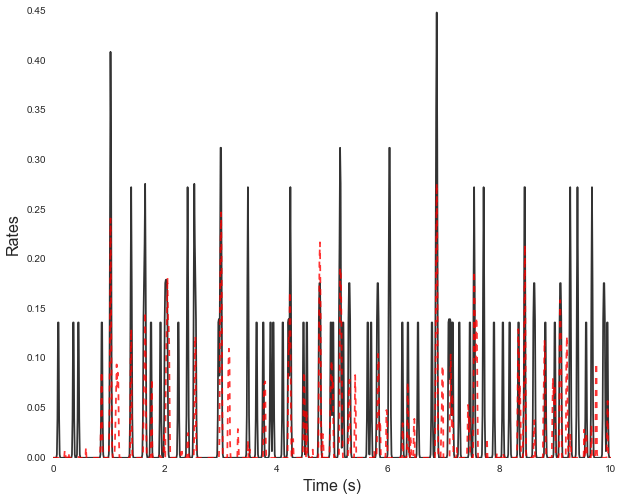

In [216]:
subset = 1000
times = np.linspace(0, 0.01*len(ln_prediction[:subset]), len(ln_prediction[:subset]))
plot(times, y[:len(ln_prediction[:subset]), cell], 'k', alpha=0.8)
plot(times, ln_prediction[:subset], 'r--', alpha=0.8)
xlabel('Time (s)', fontsize=16)
ylabel('Rates', fontsize=16)

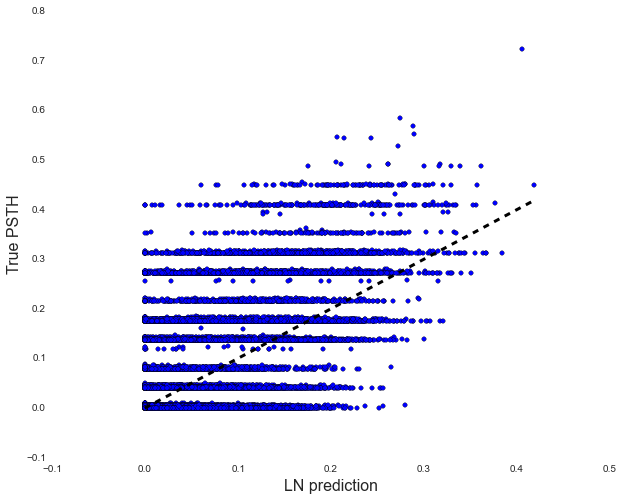

In [217]:
xs = np.linspace(np.min(ln_prediction), np.max(ln_prediction), 100)
scatter(ln_prediction, y[:len(ln_prediction),cell])
plot(xs,xs,'k--', linewidth=3)
xlabel('LN prediction', fontsize=16)
ylabel('True PSTH', fontsize=16)

# What is the overall correlation coefficient?

In [218]:
ln_corrcoef, alpha = pearsonr(ln_prediction, y[:len(ln_prediction),cell])
print 'The correlation coefficient between true rates and best LN model is %f.' %(ln_corrcoef)

The correlation coefficient between true rates and best LN model is 0.638061.


# How does the LN model perform on held-out data?

In [178]:
test         = 2000
data_amounts = [6000, 18000, 36000, 60000, 90000, 120000, 180000, 240000, X.shape[0]-test]

In [219]:
#train_acc_history = {}
#test_acc_history  = {}
#sta_history       = {}
batchSize = 100

for train in data_amounts:
    print 'Using %i datapoints.' %(train)
    
    drawIndices = np.random.choice(X.shape[0], size=(train+test), replace=False)
    trainMask = drawIndices[:train]
    testMask  = drawIndices[train:]

    #X_train = X[trainMask]
    #X_test  = X[testMask]

    # move labels into same space as X
    y_train = y[trainMask, cell]
    y_test  = y[testMask, cell]
    
    # Fit linear filter to training data
    X_sta_train        = sta_memmap(trainMask, X, y_train)
    sta_history[train] = X_sta_train

    print 'made sta'
    
    # Generate linear predictions
    l_pred_train = np.zeros(y_train.shape)
    l_pred_test  = np.zeros(y_test.shape)
    for it in xrange(y_train.shape[0] / batchSize):
        trainMask_batch = trainMask[it*batchSize:(it+1)*batchSize]
        l_pred_train[it*batchSize:(it+1)*batchSize] = np.tensordot(X[trainMask_batch], X_sta_train, axes=3)
    for it in xrange(y_test.shape[0] / batchSize):
        testMask_batch = testMask[it*batchSize:(it+1)*batchSize]
        l_pred_test[it*batchSize:(it+1)*batchSize]  = np.tensordot(X[testMask_batch], X_sta_train, axes=3)
        
    print 'made linear predictions'

    # Fit logistic nonlinearity to training data
    popt, pcov = curve_fit(logistic, l_pred_train, y_train)
    
#     print 'fit logistic nonlinearity'

    # Generate nonlinear predictions from nonlinearity trained on (X_train, y_train)
    ln_pred_train = np.zeros(y_train.shape)
    ln_pred_test  = np.zeros(y_test.shape)
    for it in xrange(y_train.shape[0] / batchSize):
        trainMask_batch = trainMask[it*batchSize:(it+1)*batchSize]
        ln_pred_train[it*batchSize:(it+1)*batchSize] = logistic(l_pred_train[it*batchSize:(it+1)*batchSize], *popt)
    for it in xrange(y_test.shape[0] / batchSize):
        testMask_batch = testMask[it*batchSize:(it+1)*batchSize]
        ln_pred_test[it*batchSize:(it+1)*batchSize]  = logistic(l_pred_test[it*batchSize:(it+1)*batchSize], *popt)

            
    print 'made nonlinear prediction'

    ln_corrcoef_train, alpha = pearsonr(ln_pred_train, y_train)
    ln_corrcoef_test, alpha  = pearsonr(ln_pred_test,  y_test)
    print 'Corr Coeff between LN model and true PSTH: train: %f, test: %f.' %(ln_corrcoef_train, ln_corrcoef_test)
    
    train_acc_history[train].append(ln_corrcoef_train)
    test_acc_history[train].append(ln_corrcoef_test)

Using 6000 datapoints.
0
made sta
made linear predictions
made nonlinear prediction
Corr Coeff between LN model and true PSTH: train: 0.969617, test: 0.045880.
Using 18000 datapoints.
0
made sta
made linear predictions
made nonlinear prediction
Corr Coeff between LN model and true PSTH: train: 0.931627, test: 0.094073.
Using 36000 datapoints.
0
made sta
made linear predictions
made nonlinear prediction
Corr Coeff between LN model and true PSTH: train: 0.889636, test: 0.103309.
Using 60000 datapoints.
0
made sta
made linear predictions
made nonlinear prediction
Corr Coeff between LN model and true PSTH: train: 0.843312, test: 0.111641.
Using 90000 datapoints.
0
made sta
made linear predictions
made nonlinear prediction
Corr Coeff between LN model and true PSTH: train: 0.795896, test: 0.188719.
Using 120000 datapoints.
0
100000
made sta
made linear predictions
made nonlinear prediction
Corr Coeff between LN model and true PSTH: train: 0.760011, test: 0.242573.
Using 180000 datapoints.
0


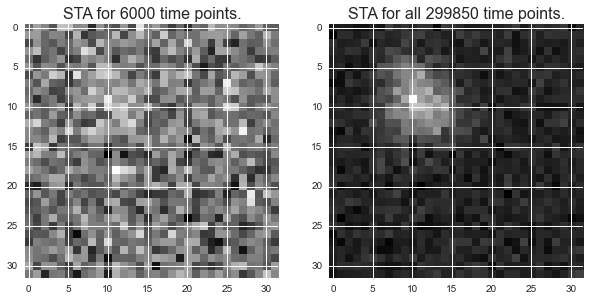

In [125]:
fig = gcf()
fig.set_size_inches((10,5))

ind = 0
subplot(1,2,1)
imshow(sta_history[data_amounts[ind]][30])
title('STA for %d time points.' %(data_amounts[ind]), fontsize=16)
subplot(1,2,2)
imshow(X_sta[30])
title('STA for all %d time points.' %(X.shape[0]), fontsize=16)

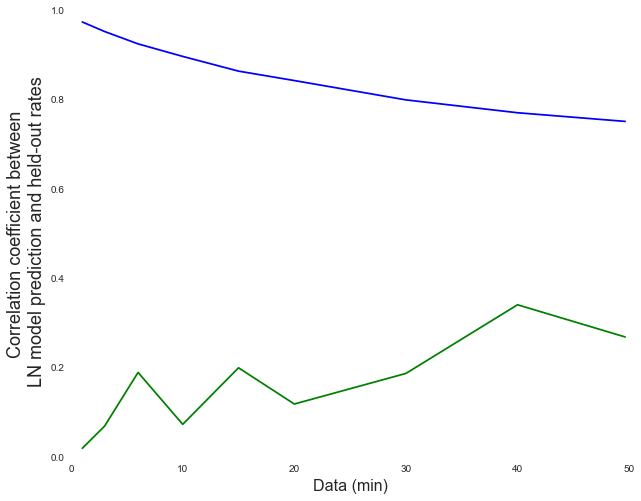

In [129]:
import operator
sorted_train_acc_history = sorted(train_acc_history.items(), key=operator.itemgetter(0))
sorted_test_acc_history  = sorted(test_acc_history.items(), key=operator.itemgetter(0))
plot([0.01*d[0]/60. for d in sorted_train_acc_history], [d[1] for d in sorted_train_acc_history],'b')
plot([0.01*d[0]/60 for d in sorted_test_acc_history], [d[1] for d in sorted_test_acc_history],'g')
xlabel('Data (min)', fontsize=16)
ylabel('Correlation coefficient between \n LN model prediction and held-out rates', fontsize=18)

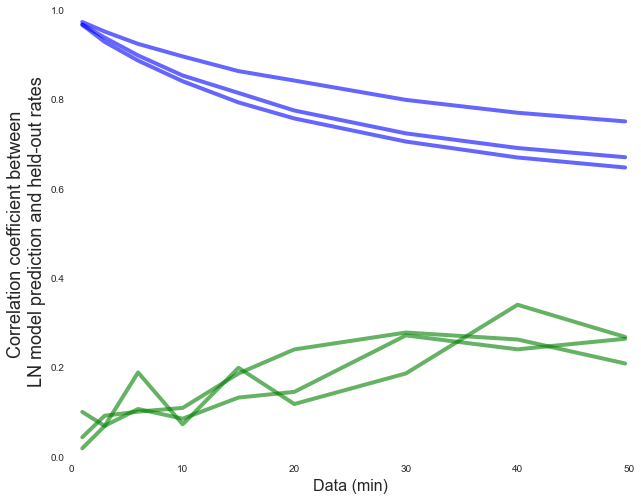

In [221]:
import operator
sorted_train_acc_history = sorted(train_acc_history.items(), key=operator.itemgetter(0))
sorted_test_acc_history  = sorted(test_acc_history.items(), key=operator.itemgetter(0))
plot([0.01*d[0]/60. for d in sorted_train_acc_history], [d[1] for d in sorted_train_acc_history],'b', alpha=0.6, linewidth=4)
plot([0.01*d[0]/60 for d in sorted_test_acc_history], [d[1] for d in sorted_test_acc_history],'g', alpha=0.6, linewidth=4)
xlabel('Data (min)', fontsize=16)
ylabel('Correlation coefficient between \n LN model prediction and held-out rates', fontsize=18)

# Train a 2 layer convnet

In [310]:
from utils.classifiers.convnet import init_two_layer_convnet
from utils.classifiers.convnet import two_layer_convnet

[autoreload of scipy.stats._discrete_distns failed: Traceback (most recent call last):
  File "/Users/lmcintosh/Git/ipython/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name entr
]
[autoreload of numpy.compat failed: Traceback (most recent call last):
  File "/Users/lmcintosh/Git/ipython/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name _inspect
]
[autoreload of scipy.stats failed: Traceback (most recent call last):
  File "/Users/lmcintosh/Git/ipython/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name mstats
]
[autoreload of numpy.core failed: Traceback (most recent call last):
  File "/Users/lmcintosh/Git/ipython/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name mult

In [307]:
model = init_two_layer_convnet(input_shape=X[0].shape, num_classes=1, filter_size=9, 
                               num_filters=16, weight_scale=10e-5) # weight_scale=0.015

### Work on subset of the total data

In [308]:
cell = cell

# Divide examples into training, validation, and test sets
numTrain = 50000
numVal   = 500
numTest  = 500

drawIndices = np.random.choice(X.shape[0], size=(numTrain+numVal+numTest), replace=False)
trainMask = drawIndices[:numTrain]
valMask   = drawIndices[numTrain:-numTest]
testMask  = drawIndices[-numTest:]

# don't need to zero mean data since we loaded stim_norm

In [300]:
X[trainMask].shape

(50000, 40, 12, 12)

In [23]:
X[valMask].shape

(1000, 40, 32, 32)

In [24]:
X[testMask].shape

(1000, 40, 32, 32)

In [25]:
y[:,cell][valMask].shape

(1000,)

### Memmap test

starting iteration  0
Finished epoch 0 / 5: cost 0.140208, train: 0.014144, val -0.056861, lr 5.000000e-05
Train preds in (0.004076, 0.032250), val preds in (0.002064, 0.002406), truth in (0.000000, 0.452231).
Finished epoch 0 / 5: cost 0.111941, train: -0.032246, val 0.003933, lr 5.000000e-05
starting iteration  10
Train preds in (0.003339, 0.040771), val preds in (0.004426, 0.031733), truth in (0.000000, 0.488557).
Finished epoch 0 / 5: cost 0.095423, train: -0.035524, val -0.040765, lr 5.000000e-05
Train preds in (0.002128, 0.043752), val preds in (0.002840, 0.039482), truth in (0.000000, 0.448872).
Finished epoch 0 / 5: cost 0.087991, train: -0.018731, val -0.014116, lr 5.000000e-05
starting iteration  20
Train preds in (0.001687, 0.050571), val preds in (0.001917, 0.045829), truth in (0.000000, 0.448872).
Finished epoch 0 / 5: cost 0.095154, train: 0.004480, val -0.060607, lr 5.000000e-05
Train preds in (0.001131, 0.052760), val preds in (0.001424, 0.054841), truth in (0.000000, 0

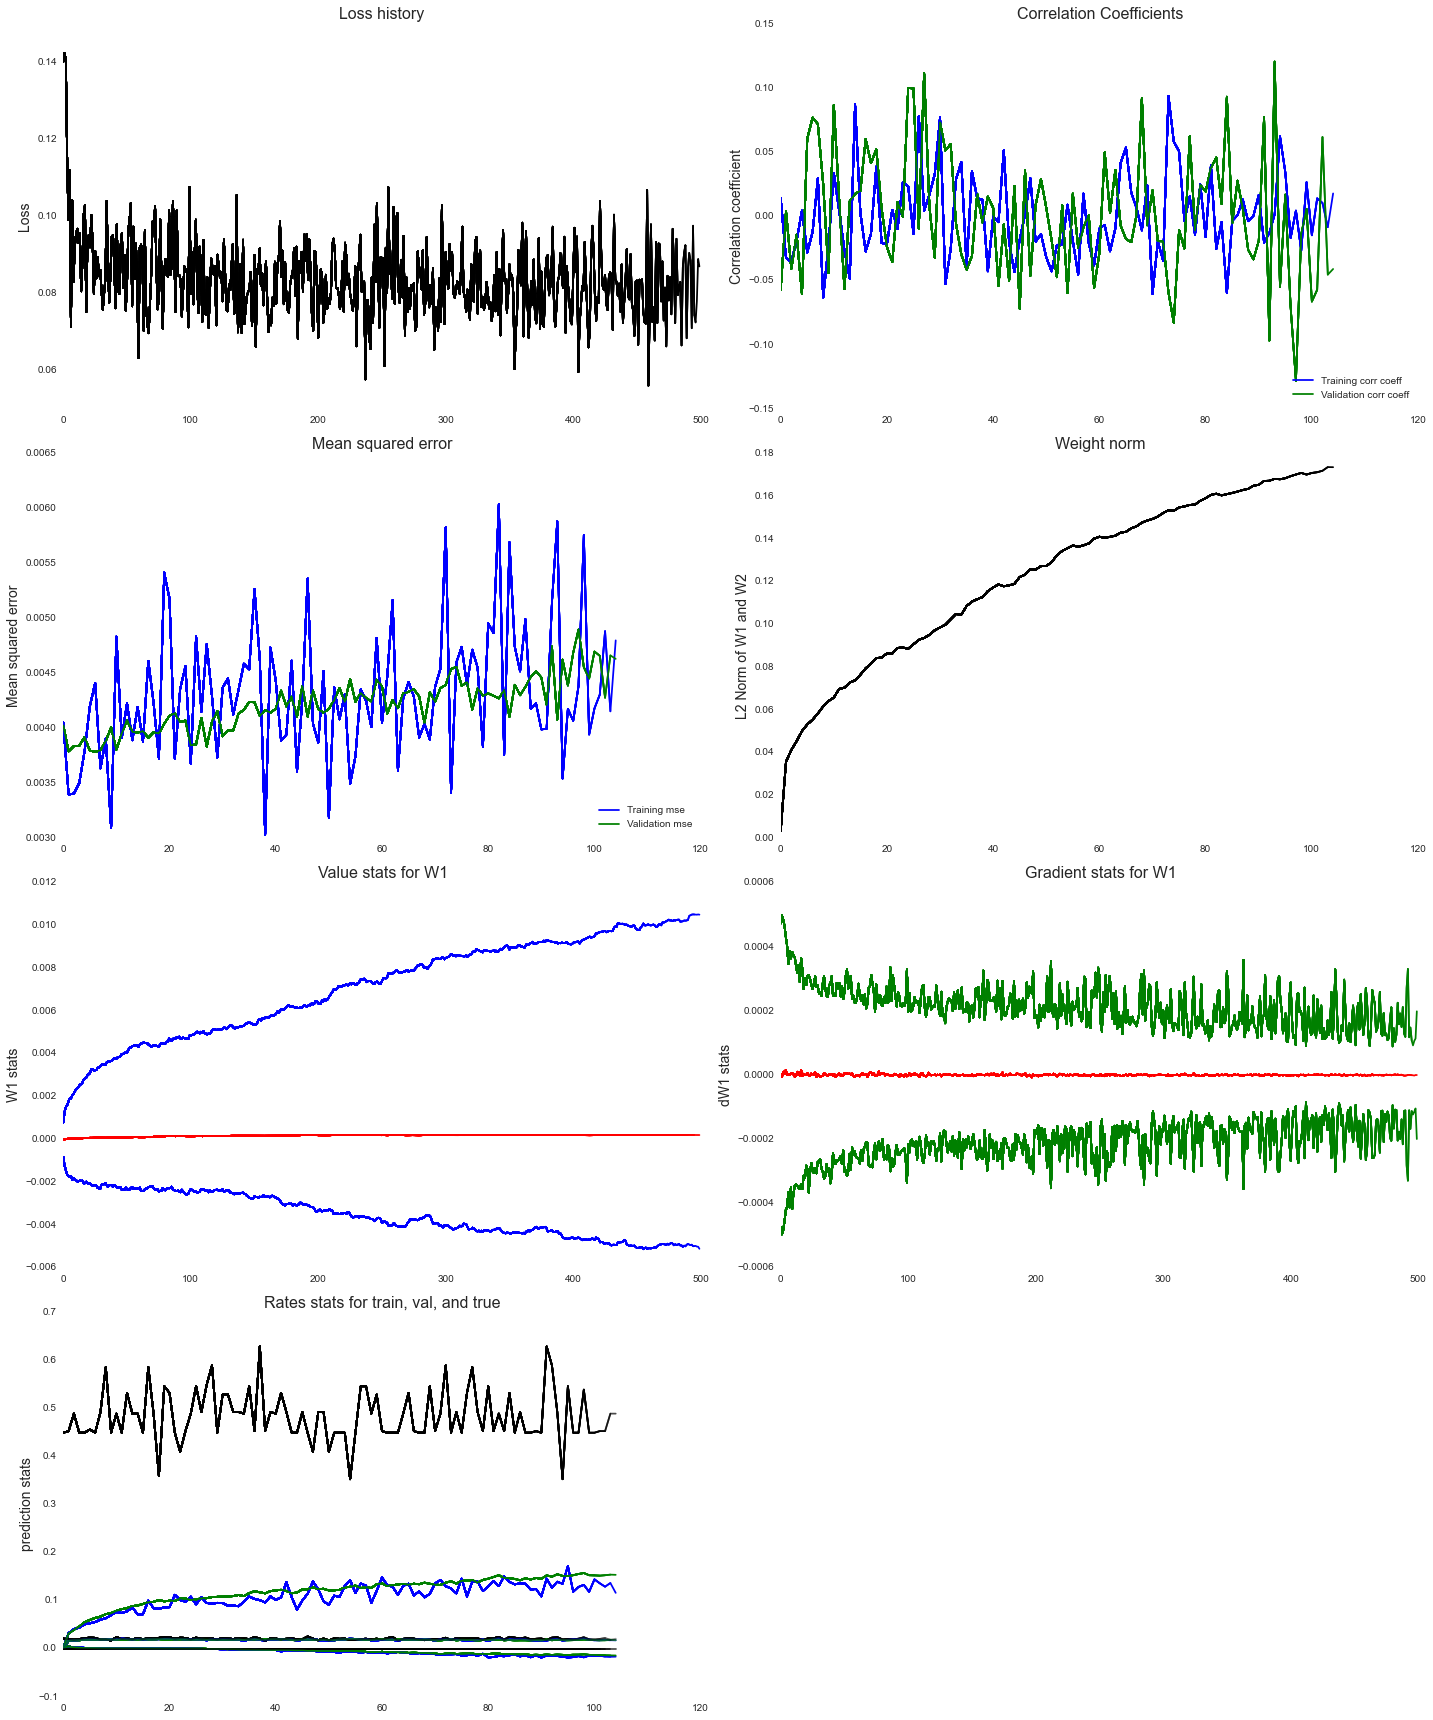

In [309]:
from utils.classifier_trainer import ClassifierTrainer

trainer = ClassifierTrainer()
learning_rate = 5e-5
reg = 0.0 #0.001
dropout = 1.0
num_epochs = 5

# choose best learning rate from cross validation with 1 epoch
#lr_hist = {} # for lr in logspace(-5,-1,10):
#learning_rate = lr_hist.keys()[np.argmin(lr_hist.values())] # lr of 0.00016681005372000591 for 0.2425 val acc

# choose best regularization from cross validation with 1 epoch
#reg_hist = {} # for r in logspace(-5,-1,10)
#reg = reg_hist.keys()[np.argmin(reg_hist.values())] # r of 0.00016681005372000591 for 0.2425 val acc


#best_model = None
#best_val_acc = 0.0 # np.inf

#for reg in logspace(-5,-1,10):
#for learning_rate in logspace(-4,-1,10):
finetuned_model, loss_history, train_acc_history, val_acc_history = trainer.train_memmap(X, y[:,cell], trainMask, 
                                                                                  valMask, model, two_layer_convnet,
                                                                                  learning_rate=learning_rate, 
                                                                                  reg=reg, update='rmsprop',
                                                                                  dropout=dropout, 
                                                                                  num_epochs=num_epochs, 
                                                                                  batch_size=500, verbose=True,
                                                                                 acc_frequency=5, save_plots=True)
#print 'Validation error %s for learning rate %s.' %(np.max(val_err_history), learning_rate)
#print 'Validation error %s for regularization %s.' %(np.min(val_err_history), reg)

if np.max(val_acc_history) > best_val_acc:
    best_model = finetuned_model
    best_val_acc = np.max(val_acc_history)

#lr_hist[learning_rate] = np.min(val_err_history)
#reg_hist[reg] = np.min(val_err_history)

In [293]:
tmp = model.copy()

In [302]:
tmp2 = model.copy()

In [282]:
model['W1'][0][30].shape

(9, 9)

<matplotlib.colorbar.Colorbar instance at 0x3e78b8cf8>

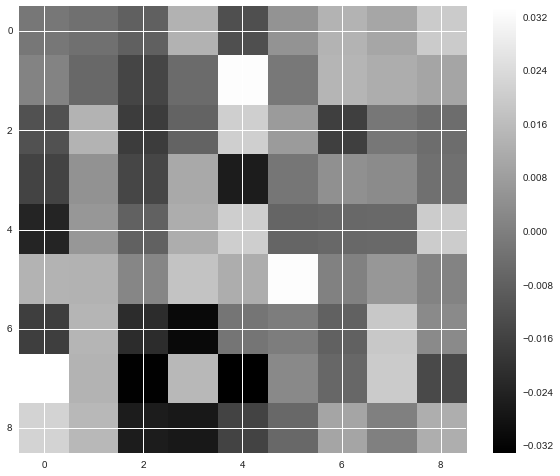

In [289]:
imshow(model['W1'][5][30])
colorbar()

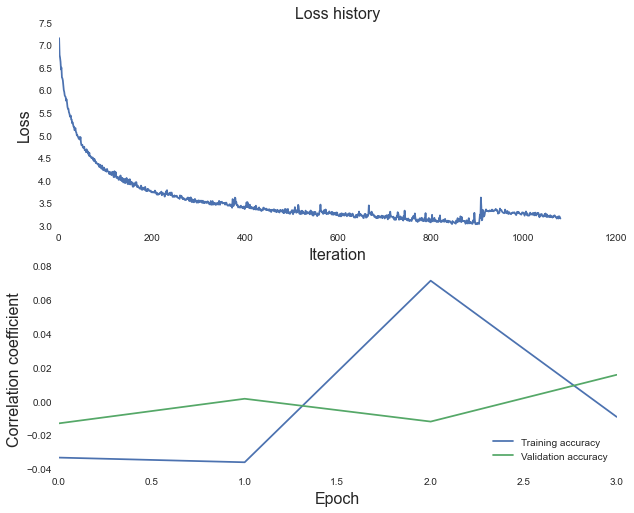

In [236]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(loss_history)
plt.title('Loss history', fontsize=16)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Loss', fontsize=16)
#yscale('log')

ax2 = plt.subplot(2, 1, 2)
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Correlation coefficient', fontsize=16)

# Train a 3 layer convnet

In [ ]:
from utils.classifiers.convnet import init_three_layer_convnet
from utils.classifiers.convnet import three_layer_convnet

In [ ]:
model = init_three_layer_convnet(input_shape=X[0].shape, num_classes=1, filter_size=9, 
                               num_filters=(16, 32), weight_scale=10e-5) # weight_scale=0.015

### Work on subset of the total data

In [ ]:
cell = cell

# Divide examples into training, validation, and test sets
numTrain = 50000
numVal   = 500
numTest  = 500

drawIndices = np.random.choice(X.shape[0], size=(numTrain+numVal+numTest), replace=False)
trainMask = drawIndices[:numTrain]
valMask   = drawIndices[numTrain:-numTest]
testMask  = drawIndices[-numTest:]

# don't need to zero mean data since we loaded stim_norm

In [ ]:
from utils.classifier_trainer import ClassifierTrainer

trainer = ClassifierTrainer()
learning_rate = 5e-6
reg = 0.0 #0.001
dropout = 1.0
num_epochs = 2

# choose best learning rate from cross validation with 1 epoch
#lr_hist = {} # for lr in logspace(-5,-1,10):
#learning_rate = lr_hist.keys()[np.argmin(lr_hist.values())] # lr of 0.00016681005372000591 for 0.2425 val acc

# choose best regularization from cross validation with 1 epoch
#reg_hist = {} # for r in logspace(-5,-1,10)
#reg = reg_hist.keys()[np.argmin(reg_hist.values())] # r of 0.00016681005372000591 for 0.2425 val acc


#best_model = None
#best_val_acc = 0.0 # np.inf

#for reg in logspace(-5,-1,10):
#for learning_rate in logspace(-4,-1,10):
finetuned_model, loss_history, train_acc_history, val_acc_history = trainer.train_memmap(X, y[:,cell], trainMask, 
                                                                                  valMask, model, three_layer_convnet,
                                                                                  learning_rate=learning_rate, 
                                                                                  reg=reg, update='rmsprop',
                                                                                  dropout=dropout, 
                                                                                  num_epochs=num_epochs, 
                                                                                  batch_size=50, verbose=True,
                                                                                 acc_frequency=5, save_plots=True)
#print 'Validation error %s for learning rate %s.' %(np.max(val_err_history), learning_rate)
#print 'Validation error %s for regularization %s.' %(np.min(val_err_history), reg)

if np.max(val_acc_history) > best_val_acc:
    best_model = finetuned_model
    best_val_acc = np.max(val_acc_history)

#lr_hist[learning_rate] = np.min(val_err_history)
#reg_hist[reg] = np.min(val_err_history)

In [ ]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(loss_history)
plt.title('Loss history', fontsize=16)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Loss', fontsize=16)
#yscale('log')

ax2 = plt.subplot(2, 1, 2)
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Correlation coefficient', fontsize=16)